In [1]:
#Imports
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
import glob
import matplotlib.pyplot as plt

from nilearn import plotting, image
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix

from nilearn.plotting import plot_design_matrix

# Data path
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/joagra/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

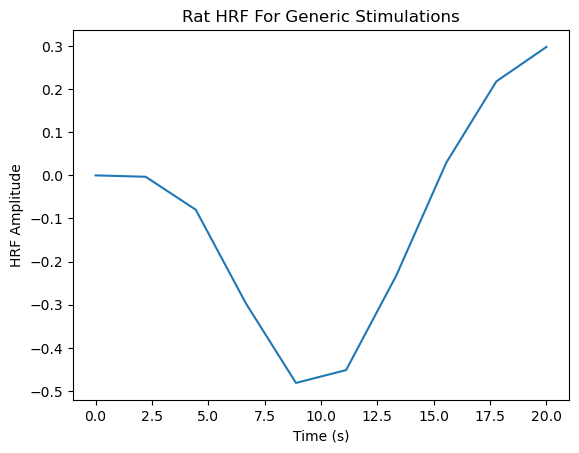

array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])

In [7]:
# -- Generic Rat HRF 

# --- Generic rat HRF: stim >5sec --- 

    #Rref
#Matlab script H. Lambert (2019)        
#https://app.codecov.io/gh/nilearn/nilearn/pull/2942/blob/nilearn/glm/first_level/hemodynamic_models.py

#Evaluating the difference of two gamma probability density functions (PDFs)
# duration : stimulation duration in seconds
# tr : in seconds
# h1, h2, l1, and l2 : define the shape and scale parameters
# V = ratio parameter 

from scipy.stats import gamma

def rat_hrf_generic(tr, duration, oversampling=1, onset=0.0):
    dt = tr / oversampling
    time_length = duration + onset
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    response_function *= -1

    plt.plot(time_stamps, response_function)
    plt.xlabel('Time (s)')
    plt.ylabel('HRF Amplitude')
    plt.title('Rat HRF For Generic Stimulations')
    plt.show()

    return response_function

#def generic_time_derivative(tr, duration, oversampling=1, onset=0.0):
 #   do = 0.1
 #   first = rat_hrf_generic(tr, duration, oversampling, onset)
 #   second = rat_hrf_generic(tr, duration, oversampling, onset + do)
 #   drf = (first - second) / do
 #   print(first)
 #   print(second)
 #   print(onset + do)

 #  return drf
    
rat_hrf_generic(2.0, 20)
#generic_time_derivative(2.0, 20)

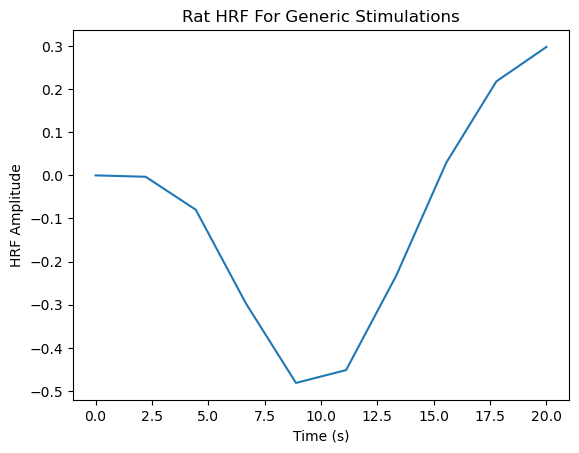

([array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])], 'Rat HRF', ['main'])
[array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])]


In [9]:
# Define response function models

hrf_models = [("spm + derivative + dispersion", "SPM HRF", None),
             ("glover + derivative + dispersion", "Glover HRF", None),
             ([rat_hrf_generic], "Rat HRF", ["main"]),]
                       
selected_model = hrf_models[2]                     # select a  model
hrf_model, model_title, labels = selected_model    # Unpack the selected model


print(selected_model)
print(hrf_model)

In [10]:
# Compute regressors 

tr = 2.0
onset = 0.0
duration = 20
onsets = [60, 140, 220]
durations = [20, 20, 20]
trial_type = [1, 1, 1]
exp_condition = np.array((onsets, durations, trial_type))

frame_times = np.linspace(0, duration, 61) 
oversampling=1

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=hrf_model,
                                    frame_times=frame_times,
                                    con_id="main",
                                    oversampling=oversampling)


print(signal)
print(_labels)


ValueError: "[array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])]" is not a known hrf model. Use either a custom model or one of ['spm', 'spm + derivative', 'spm + derivative + dispersion', 'fir', 'glover', 'glover + derivative', 'glover + derivative + dispersion', None]

In [34]:
# Example from nilearn : https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_hrf.html

from scipy.stats import gamma

import numpy as np

time_length = 30.0
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

from scipy.stats import gamma


def rat_response_function(tr, oversampling=16, onset=0.0):
    """Implement the MION response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = np.linspace(
        0, time_length, np.rint(time_length / dt).astype(int)
    )
    time_stamps -= onset

    # parameters of the gamma function
    delay = 2.18
    dispersion = 1.92

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()
    #response_function *= -1

    return response_function


def mion_time_derivative(tr, oversampling=16.0):
    """Implement the MION time derivative response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor, optional

    Returns
    -------
    drf: array of shape(time_length / tr * oversampling, dtype=float)
        derived_response_function sampling on the provided grid
    """
    do = 0.1
    drf = (
        mion_response_function(tr, oversampling)
        - mion_response_function(tr, oversampling, do)
    ) / do

    return drf

# Define models 
rf_models = [
    ("spm + derivative + dispersion", "SPM HRF", None),
    ("glover + derivative + dispersion", "Glover HRF", None),
    (
        [mion_response_function, mion_time_derivative],
        "Mion RF + derivative",
        ["main", "main_derivative"],
    ),
]


for i, (rf_model, model_title, labels) in enumerate(rf_models):
    # compute signal of interest by convolution
    signal, _labels = compute_regressor(
        exp_condition=exp_condition,
        hrf_model=rf_model,
        frame_times=frame_times,
        con_id="main",
        oversampling=oversampling)

print(signal)
print(_labels)

[[ 0.00000000e+00  0.00000000e+00]
 [ 1.99947377e-02  7.02446648e-02]
 [ 7.37390047e-02  1.27739337e-01]
 [ 1.28996070e-01  9.03277604e-02]
 [ 1.61326227e-01  4.65569008e-02]
 [ 1.75202465e-01  1.41201133e-02]
 [ 1.76099175e-01 -7.83010837e-03]
 [ 1.68553436e-01 -2.15506473e-02]
 [ 1.55985485e-01 -2.92327199e-02]
 [ 1.40842597e-01 -3.26826925e-02]
 [ 1.24802504e-01 -3.32923027e-02]
 [ 1.08963643e-01 -3.20914893e-02]
 [ 9.40029056e-02 -2.98192530e-02]
 [ 8.02992175e-02 -2.69907491e-02]
 [ 6.80270211e-02 -2.39539354e-02]
 [ 5.72252156e-02 -2.09347869e-02]
 [ 4.78468862e-02 -1.80721789e-02]
 [ 3.97944146e-02 -1.54441600e-02]
 [ 3.29436940e-02 -1.30873630e-02]
 [ 2.71603681e-02 -1.10111001e-02]
 [ 2.23103293e-02 -9.20742492e-03]
 [ 1.82661561e-02 -7.65818467e-03]
 [ 1.49107345e-02 -6.33985936e-03]
 [ 1.21389707e-02 -5.22679555e-03]
 [ 9.85824998e-03 -4.29329275e-03]
 [ 7.98810529e-03 -3.51488235e-03]
 [ 6.45941855e-03 -2.86904852e-03]
 [ 5.21337621e-03 -2.33557223e-03]
 [ 4.20032624e-03 -1

In [12]:
print(rf_model)

[<function mion_response_function at 0x7f80908baf80>, <function mion_time_derivative at 0x7f80908bab90>]


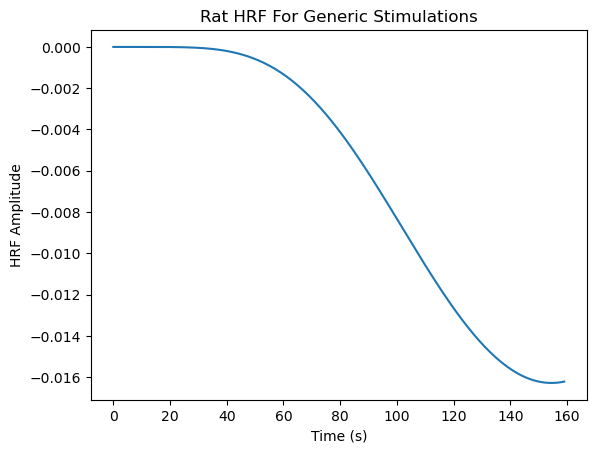

In [19]:

plt.plot(rat_hrf_generic(tr=1))
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF For Generic Stimulations')
plt.show()

In [31]:
from scipy.stats import gamma

def rat_hrf_generic(tr, oversampling=16, onset=0.0):
    dt = tr / oversampling
    #time_length = duration + onset
    time_length = onset + 20
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    #response_function *= -1


    return response_function

In [37]:
print(exp_condition)
print(frame_times)

[[0.]
 [1.]
 [1.]]
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30. ]


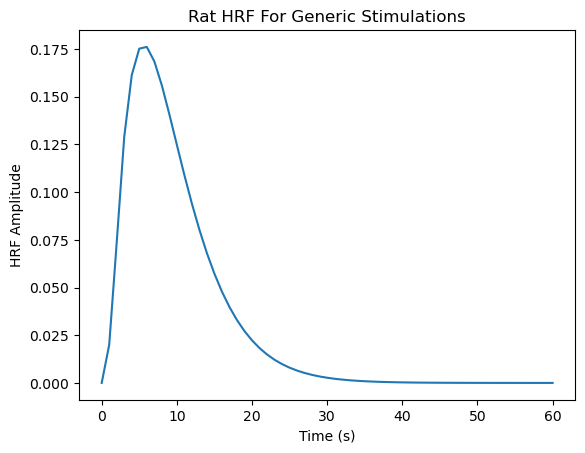

In [50]:
import numpy as np

time_length = 30.0
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

from scipy.stats import gamma


def rat_response_function(tr, oversampling=16, onset=0.0):
    """Implement the MION response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = np.linspace(
        0, time_length, np.rint(time_length / dt).astype(int)
    )
    time_stamps -= onset

    # parameters of the gamma function
    delay = 2.18
    dispersion = 1.92

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()
    #response_function *= -1

    return response_function

signal, _labels = compute_regressor(
        exp_condition=exp_condition,
        hrf_model=rat_response_function,
        frame_times=frame_times,
        con_id="main",
        oversampling=oversampling)

plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF For Generic Stimulations')
plt.show()

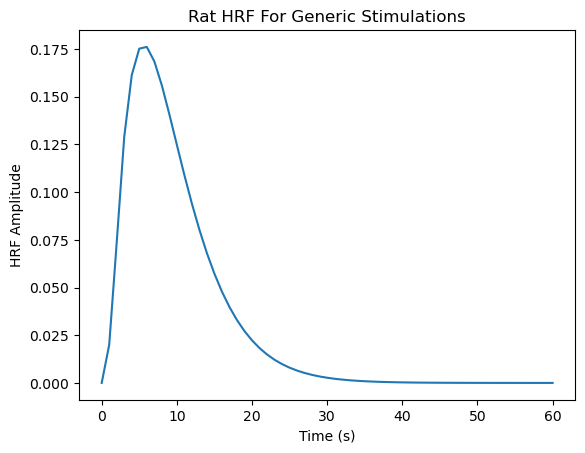

In [51]:
plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF For Generic Stimulations')
plt.show()

In [52]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

index=0
    
subj_num=str(df.iloc[index]['rat.sub'])[:-2]

    
subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
func_img = nib.load(subject_path) 
    
     # --- Events regressor --- 
    
n_scans = func_img.shape[3]   
tr = (df.iloc[index]['func.TR']) 
n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset
frame_times = np.arange(n_scans) * tr 
    
onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]  # Get onsets from metadata file
scan_start_times = frame_times[:n_tr]                                  # Get the start times of each scan
onsets = onset_metadata - scan_start_times                             # Subtract the start time of each scan

durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
trial_type = np.ones_like(onsets)
    
events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
exp_condition = np.array((onsets, durations, trial_type))



    
    

In [53]:
print(exp_condition)

[[ 60. 138. 216.]
 [ 20.  20.  20.]
 [  1.   1.   1.]]


In [54]:
    # --- Specify the rat hrf --- 
    
duration_1_stim = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
    
print('TR:', tr)
print('n stim:', n_tr)
print('stim duration:', duration_1_stim)

signal, _labels = compute_regressor(exp_condition, rat_response_function, frame_times)

TR: 2.0
n stim: 3
stim duration: 20


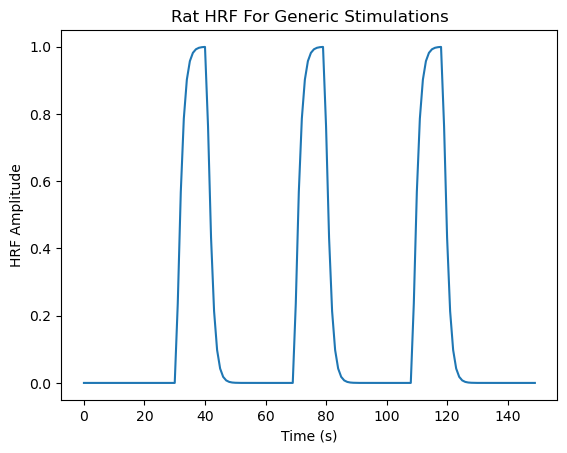

In [55]:
plt.plot(signal)
plt.xlabel('Time (s)')
plt.ylabel('HRF Amplitude')
plt.title('Rat HRF For Generic Stimulations')
plt.show()